<a href="https://colab.research.google.com/github/Deleon57/EDAR-REGRESSION/blob/main/KNN1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [7]:
# Load dataset
data1 = pd.read_csv("GFI_dataset.csv")

# Convert Date column to datetime
data1['Date'] = pd.to_datetime(data1['Date'])
data1 = data1.sort_values('Date')
data1.set_index('Date', inplace=True)

print(data1.head())




                  Close         High          Low         Open
Date                                                          
2012-12-31  9091.963867  9151.554951  8999.072886  9104.232763
2013-01-01  9091.963867  9091.963867  9091.963867  9091.963867
2013-01-02  9323.318359  9325.946504  9043.767691  9151.556707
2013-01-03  9335.583984  9376.772209  9183.978625  9289.138496
2013-01-04  9049.024414  9131.399905  8955.256723  9113.873744


/tmp/ipython-input-3950059256.py:5: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  data1['Date'] = pd.to_datetime(data1['Date'])


In [12]:
from statsmodels.tsa.stattools import adfuller

# Loop through each feature
for col in ["Close", "High", "Low", "Open"]:
    result = adfuller(data1[col].dropna())
    print(f"Feature: {col}")
    print("  ADF Statistic:", result[0])
    print("  p-value:", result[1])
    print("-" * 40)


Feature: Close
  ADF Statistic: -0.8927524476821448
  p-value: 0.790349769845352
----------------------------------------
Feature: High
  ADF Statistic: -1.129604601213029
  p-value: 0.7031227284341343
----------------------------------------
Feature: Low
  ADF Statistic: -1.0113363349123317
  p-value: 0.7491072102344439
----------------------------------------
Feature: Open
  ADF Statistic: -1.0917706683810122
  p-value: 0.7183424850696943
----------------------------------------


In [17]:
# Select numeric features (Close, High, Low, Open, etc.)
features = data1.select_dtypes(include=[np.number]).columns

# Calculate percentage change
data_returns = data1[features].pct_change().dropna()

# Run ADF test on each feature
for col in features:
    adf_test(data_returns[col], title=f"{col} (Returns)")



--- Close (Returns) ---
ADF Statistic      -40.179521
p-value              0.000000
# Lags Used          1.000000
# Observations    3046.000000
✅ Stationary


--- High (Returns) ---
ADF Statistic      -39.889323
p-value              0.000000
# Lags Used          1.000000
# Observations    3046.000000
✅ Stationary


--- Low (Returns) ---
ADF Statistic    -1.349928e+01
p-value           2.999034e-25
# Lags Used       1.500000e+01
# Observations    3.032000e+03
✅ Stationary


--- Open (Returns) ---
ADF Statistic      -18.951097
p-value              0.000000
# Lags Used          8.000000
# Observations    3039.000000
✅ Stationary




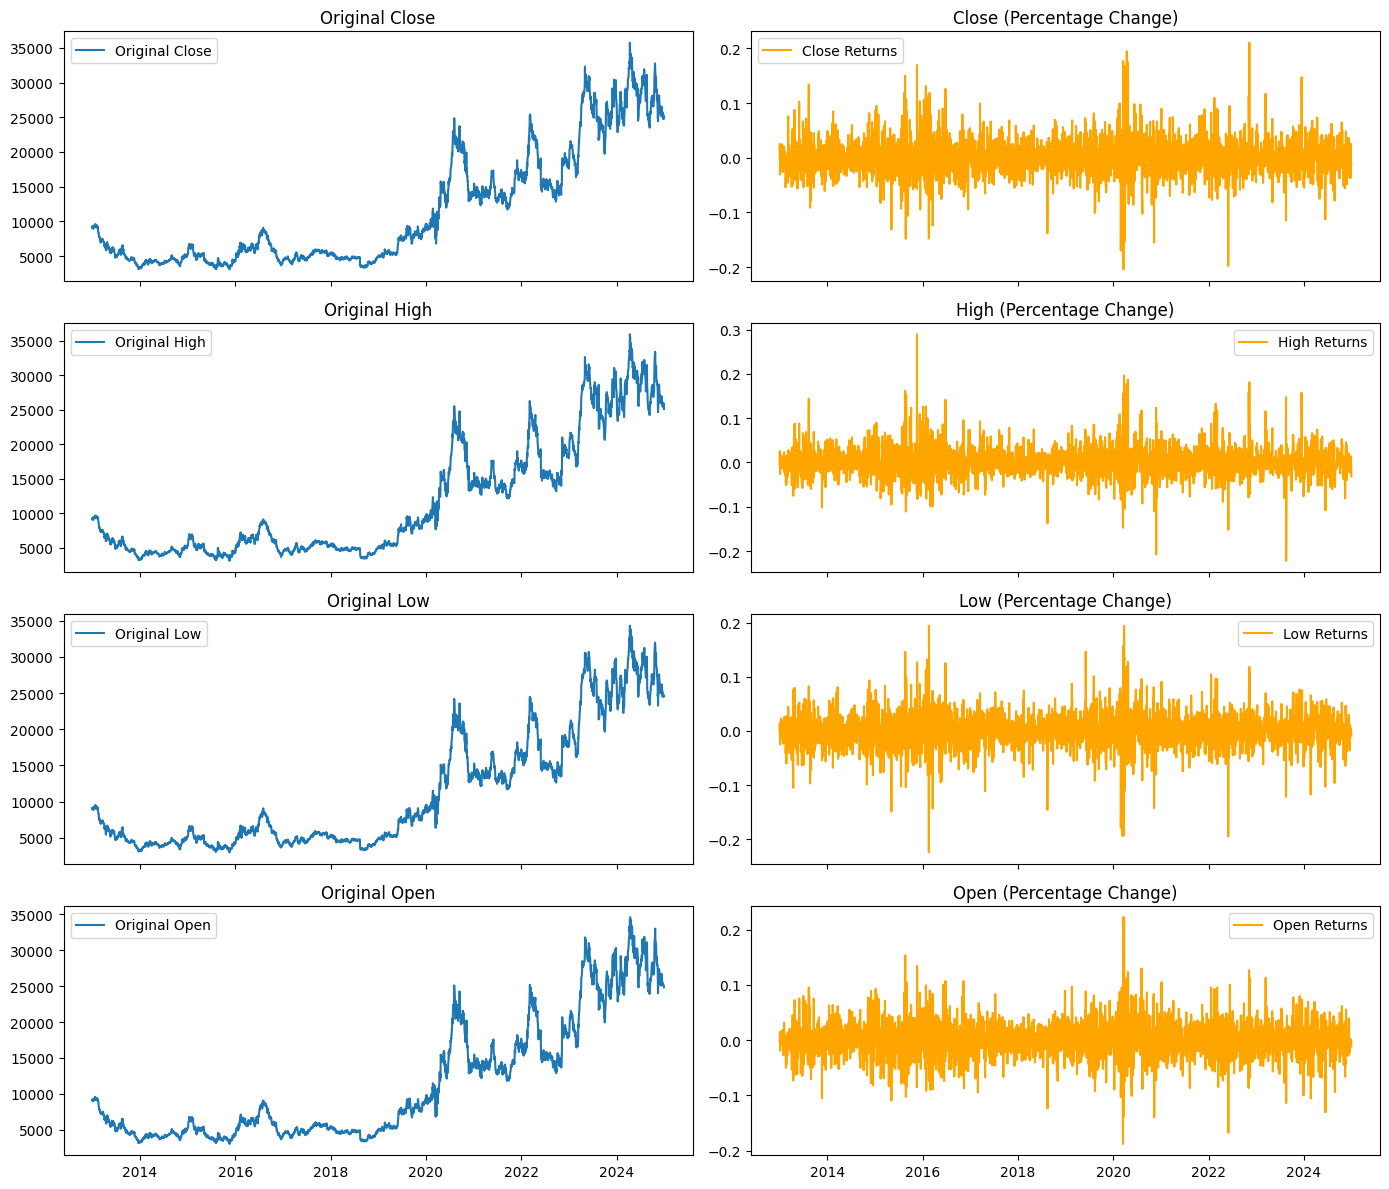

In [20]:
# Create subplots with 2 columns: Original vs Returns
n_features = len(features)
fig, axes = plt.subplots(n_features, 2, figsize=(14, 3*n_features), sharex=True)

for i, col in enumerate(features):
    # Original series
    axes[i,0].plot(data1[col], label=f"Original {col}")
    axes[i,0].set_title(f"Original {col}")
    axes[i,0].legend()

    # Returns series
    axes[i,1].plot(data_returns[col], label=f"{col} Returns", color='orange')
    axes[i,1].set_title(f"{col} (Percentage Change)")
    axes[i,1].legend()

plt.tight_layout()
plt.show()


In [21]:
# Save only the stationary returns dataset
data_returns.to_csv("GFI_dataset_returns.csv", index=True)

print("✅ Stationary dataset saved as 'GFI_dataset_returns.csv'")


✅ Stationary dataset saved as 'GFI_dataset_returns.csv'


In [24]:
# ===============================
# Train-Test Split
# ===============================
train = data_returns[data_returns.index < "2023-01-01"]
test  = data_returns[data_returns.index >= "2023-01-01"]

# Features (X) and Target (y)
X_train = train[["High", "Low", "Open"]]
y_train = train["Close"]

X_test = test[["High", "Low", "Open"]]
y_test = test["Close"]

print("Train shape:", X_train.shape, y_train.shape)
print("Test shape:", X_test.shape, y_test.shape)


Train shape: (2551, 3) (2551,)
Test shape: (497, 3) (497,)


In [25]:
# ===============================
# KNN Model
# ===============================
knn = KNeighborsRegressor(n_neighbors=5)  # you can tune n_neighbors later
knn.fit(X_train, y_train)

# ===============================
# Predictions
# ===============================
y_pred = knn.predict(X_test)

# ===============================
# Evaluation
# ===============================
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("✅ KNN Model Evaluation")
print("MSE:", mse)
print("R²:", r2)

✅ KNN Model Evaluation
MSE: 0.00028273750515529815
R²: 0.6407318805110194


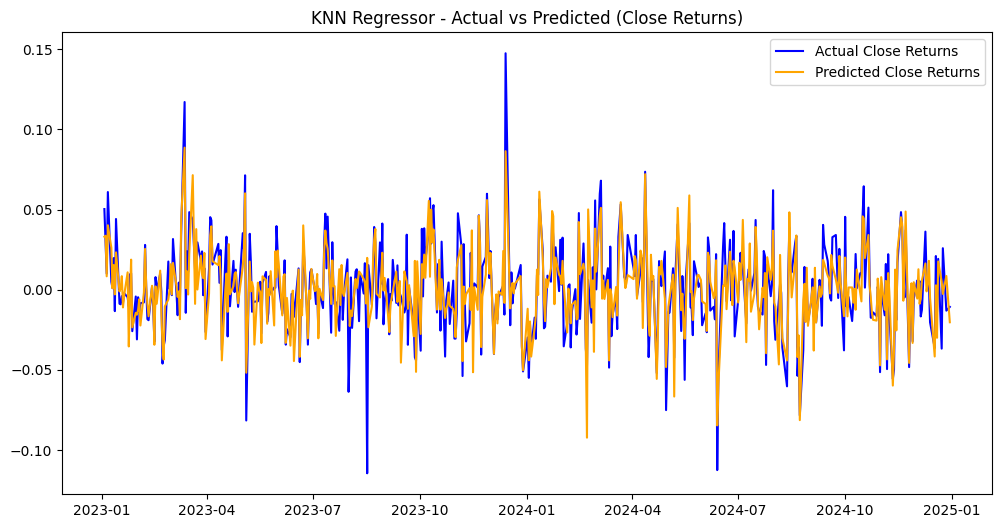

In [26]:
# ===============================
# Visualise Actual vs Predicted
# ===============================
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(y_test.index, y_test, label="Actual Close Returns", color="blue")
plt.plot(y_test.index, y_pred, label="Predicted Close Returns", color="orange")
plt.title("KNN Regressor - Actual vs Predicted (Close Returns)")
plt.legend()
plt.show()




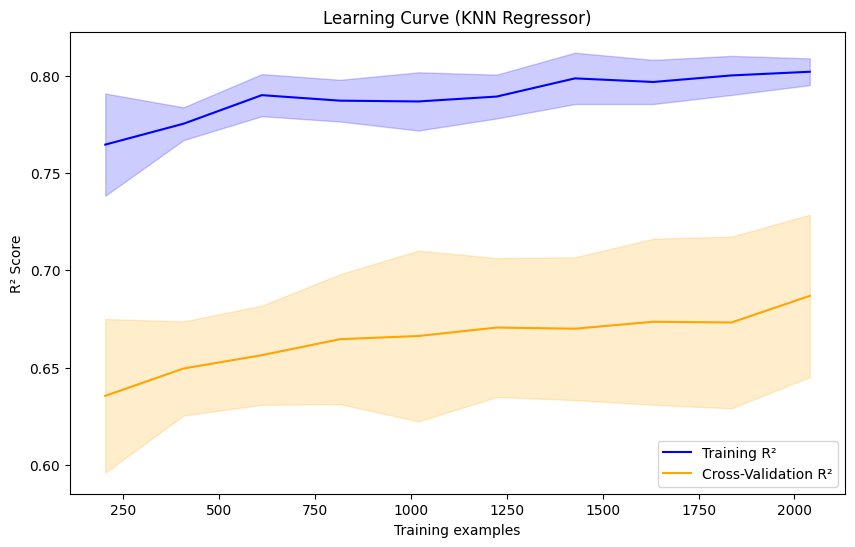

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.neighbors import KNeighborsRegressor

# ===============================
# Define KNN model
# ===============================
knn_model = KNeighborsRegressor(n_neighbors=5)  # you can tune this later

# ===============================
# Generate learning curve
# ===============================
train_sizes, train_scores, test_scores = learning_curve(
    estimator=knn_model,
    X=X_train,
    y=y_train,
    cv=5,                   # 5-fold cross validation
    scoring="r2",           # use R² score
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)

# ===============================
# Calculate mean and std
# ===============================
train_mean = np.mean(train_scores, axis=1)
train_std  = np.std(train_scores, axis=1)
test_mean  = np.mean(test_scores, axis=1)
test_std   = np.std(test_scores, axis=1)

# ===============================
# Plot Learning Curve
# ===============================
plt.figure(figsize=(10,6))
plt.plot(train_sizes, train_mean, label="Training R²", color="blue")
plt.plot(train_sizes, test_mean, label="Cross-Validation R²", color="orange")

plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2, color="blue")
plt.fill_between(train_sizes, test_mean-test_std, test_mean+test_std, alpha=0.2, color="orange")

plt.title("Learning Curve (KNN Regressor)")
plt.xlabel("Training examples")
plt.ylabel("R² Score")
plt.legend(loc="best")
plt.show()


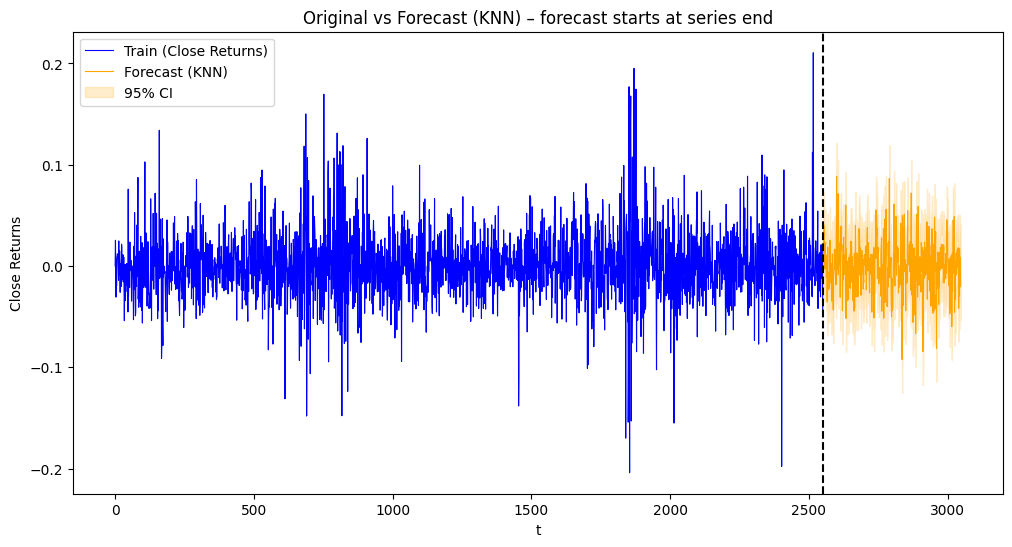

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# ===============================
# Forecast index aligned with test set
# ===============================
x_forecast = np.arange(len(y_test)) + len(y_train)

# ===============================
# Estimate 95% CI from prediction errors
# ===============================
error = y_test.values - y_pred
err_std = np.std(error)

lower = y_pred - 1.96 * err_std
upper = y_pred + 1.96 * err_std

# ===============================
# Plot Original (Train + Test) and Forecast
# ===============================
plt.figure(figsize=(12,6))

# Training data (blue)
plt.plot(range(len(y_train)), y_train.values, label="Train (Close Returns)", color="blue", linewidth=0.8)

# Test forecast (orange)
plt.plot(x_forecast, y_pred, label="Forecast (KNN)", color="orange", linewidth=0.8)

# Confidence Interval
plt.fill_between(x_forecast, lower, upper, color="orange", alpha=0.2, label="95% CI")

# Vertical line at boundary
plt.axvline(x=len(y_train), color="k", linestyle="--")

# Labels and legend
plt.title("Original vs Forecast (KNN) – forecast starts at series end")
plt.xlabel("t")
plt.ylabel("Close Returns")
plt.legend()
plt.show()


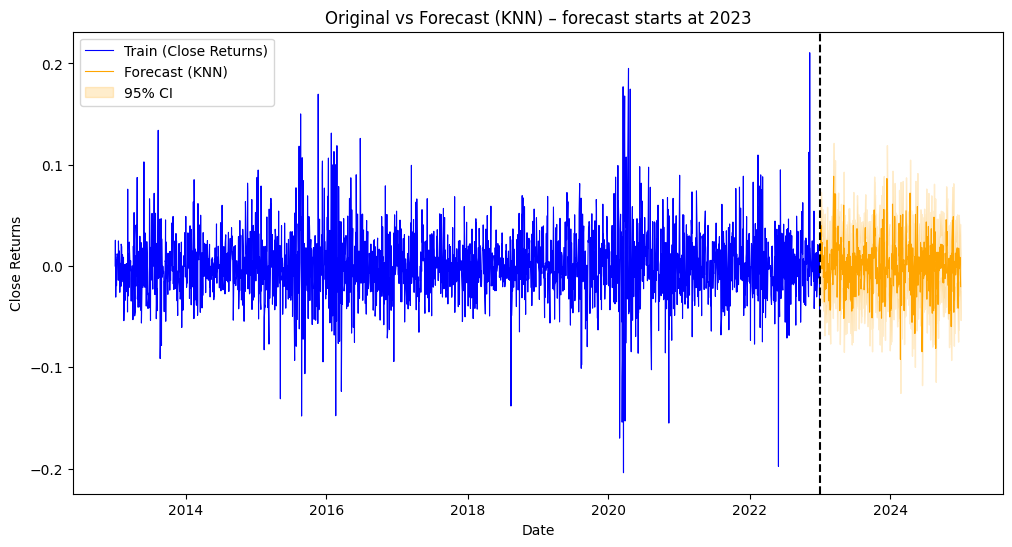

In [30]:
# ===============================
# Forecast with actual date index
# ===============================

# Error and confidence interval
error = y_test.values - y_pred
err_std = np.std(error)
lower = y_pred - 1.96 * err_std
upper = y_pred + 1.96 * err_std

plt.figure(figsize=(12,6))

# Training data (blue) – use actual index
plt.plot(y_train.index, y_train.values, label="Train (Close Returns)", color="blue", linewidth=0.8)

# Forecast (orange) – align with test index
plt.plot(y_test.index, y_pred, label="Forecast (KNN)", color="orange", linewidth=0.8)

# Confidence Interval
plt.fill_between(y_test.index, lower, upper, color="orange", alpha=0.2, label="95% CI")

# Vertical line at boundary
plt.axvline(x=y_test.index[0], color="k", linestyle="--")

# Labels and legend
plt.title("Original vs Forecast (KNN) – forecast starts at 2023")
plt.xlabel("Date")
plt.ylabel("Close Returns")
plt.legend()
plt.show()


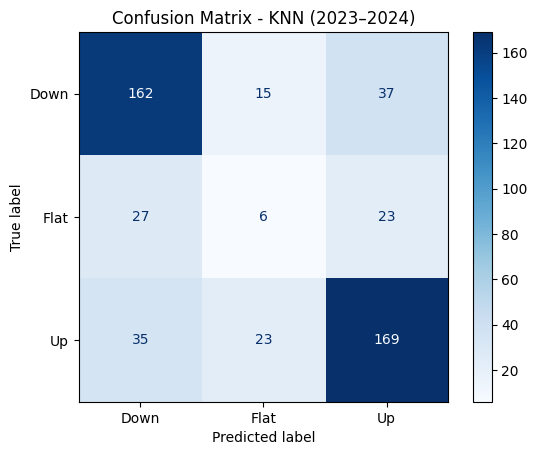

Classification Report - KNN
              precision    recall  f1-score   support

        Down       0.72      0.76      0.74       214
        Flat       0.14      0.11      0.12        56
          Up       0.74      0.74      0.74       227

    accuracy                           0.68       497
   macro avg       0.53      0.54      0.53       497
weighted avg       0.66      0.68      0.67       497



In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Ensure arrays ---
y_test_arr = np.array(y_test).flatten()
y_pred_arr = np.array(y_pred).flatten()

# --- 2. Convert regression outputs into classes ---
def to_class(delta, eps=None):
    """
    Convert price changes into classes:
    +1 = up, -1 = down, 0 = flat (within epsilon threshold)
    """
    if eps is None:
        eps = 0.1 * np.std(delta)   # threshold based on std deviation

    cls = np.zeros_like(delta, dtype=int)
    cls[delta > eps] = 1           # Up
    cls[delta < -eps] = -1         # Down
    return cls

# --- 3. Compute daily differences ---
delta_true = np.diff(y_test_arr, prepend=y_test_arr[0])
delta_pred = np.diff(y_pred_arr, prepend=y_pred_arr[0])

# --- 4. Convert differences to classes ---
true_cls = to_class(delta_true)
pred_cls = to_class(delta_pred)

# --- 5. Confusion Matrix ---
labels = [-1, 0, 1]  # Down, Flat, Up
cm = confusion_matrix(true_cls, pred_cls, labels=labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Down", "Flat", "Up"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - KNN (2023–2024)")
plt.show()

# --- 6. Classification Report ---
print("Classification Report - KNN")
print(classification_report(true_cls, pred_cls, target_names=["Down", "Flat", "Up"]))


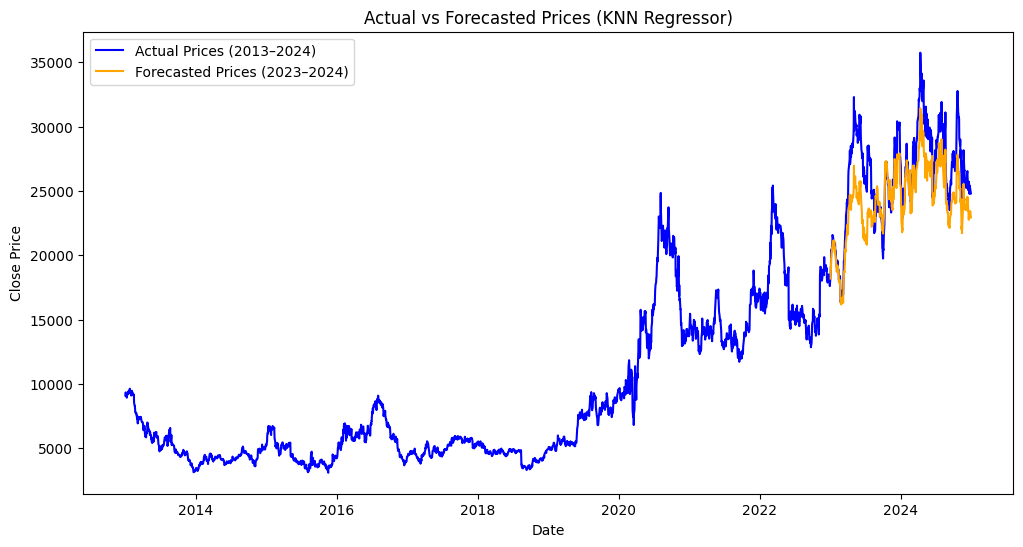

In [32]:
# ===============================
# 1. Reconstruct ACTUAL prices from returns (2013–2024)
# ===============================

# Start from the first actual price in 2013
P0 = data1["Close"].iloc[0]

# Rebuild prices from returns
reconstructed_prices = (1 + data_returns["Close"]).cumprod() * P0

# ===============================
# 2. Reconstruct FORECASTED prices from returns (2023–2024)
# ===============================

# Start from the last actual price before forecast period (end of 2022)
last_price_2022 = data1.loc[data1.index < "2023-01-01", "Close"].iloc[-1]

# Convert forecasted returns (y_pred) into price levels
forecast_prices = (1 + pd.Series(y_pred, index=y_test.index)).cumprod() * last_price_2022

# ===============================
# 3. Plot Actual vs Forecasted
# ===============================
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))

# Plot actual reconstructed prices
plt.plot(reconstructed_prices.index, reconstructed_prices, label="Actual Prices (2013–2024)", color="blue")

# Plot forecasted prices
plt.plot(forecast_prices.index, forecast_prices, label="Forecasted Prices (2023–2024)", color="orange")

plt.title("Actual vs Forecasted Prices (KNN Regressor)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()
